# Modeling gravitational-wave data as stationary Gaussian noise

Author: Javier Roulet (jroulet[at]caltech.edu)

Is this notebook you will learn to:
* use [GWpy](https://gwpy.github.io/docs/stable/) to
    * download real LIGO data
    * estimate the power spectral density (PSD)
    * whiten the data
* gain intuition about the properties of whitened vs. colored (unfiltered) data
* implement the Welch method for yourself to estimate the PSD

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gwpy.timeseries

Here we use `gwpy` to download LIGO data from the gravitational-wave open science center ([GWOSC](https://gwosc.org/)).

In [2]:
# Here we choose a random chunk of data, just not particularly glitchy
tgps = 1239082262.1  # An event

start = int(tgps) + 100
end = int(tgps) + 2000  # No events here

# Download data from LIGO-Livingston "L1" detector
timeseries = gwpy.timeseries.TimeSeries.fetch_open_data('L1', start, end, cache=True)

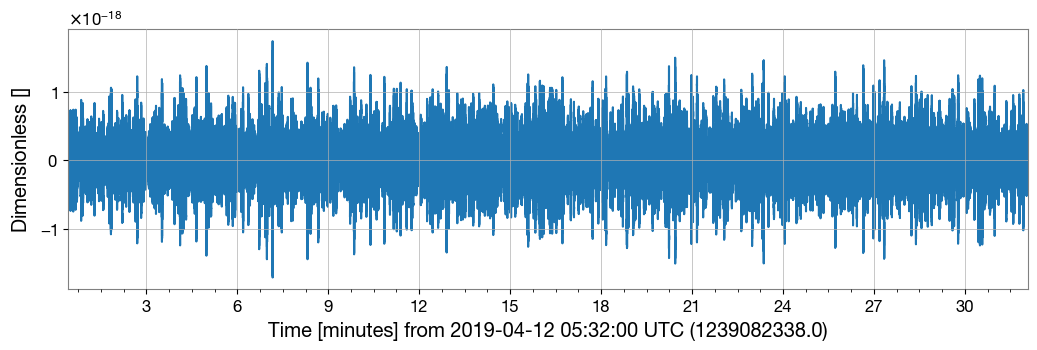

In [3]:
timeseries.plot();

## Measuring the power spectral density
A PSD is usually measured by averaging estimates from multiple segments of data. Each estimate consists of the power in each frequency bin, i.e. the absolute value squared of the frequency-domain data.
We also define the amplitude spectral density, $\text{ASD}(f) = \sqrt{\text{PSD}(f)}$

Measuring a PSD often involves tradeoffs: we can increase the frequency resolution by increasing the length of each segment (and therefore better resolve sharp features like spectral lines). On the flip side, this means we have fewer segments to average and the estimate in each bin is noisier. We can fix this by collecting more data, but then we may need to worry about the stationarity of the PSD over time.

Here we use `gwpy` to measure the PSD using different segment lengths (`fftlength`), and zoom in at different levels to observe the differences. The operational frequency range of the detectors is above 10 Hz. LIGO-Virgo-KAGRA data are uncalibrated below 10 Hz, and GWOSC data downsampled to 4096 Hz (such as the one we just downloaded) are invalid above 1600 Hz, due to the way they were downsampled (https://gwosc.org/yellow_box/).

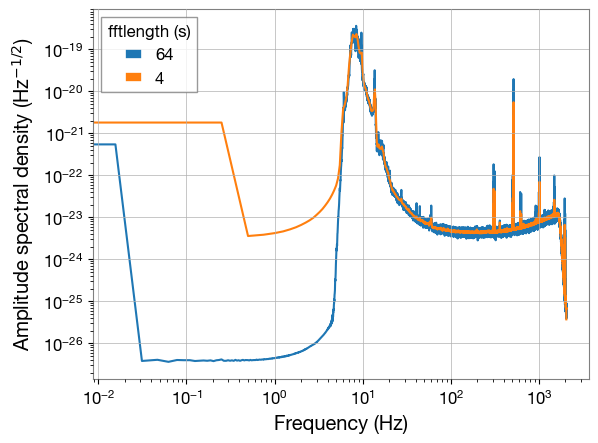

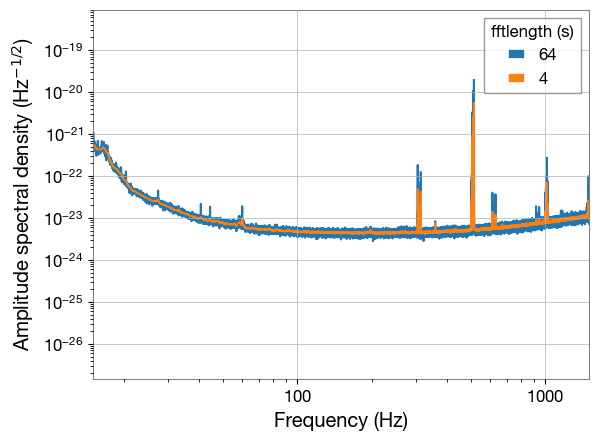

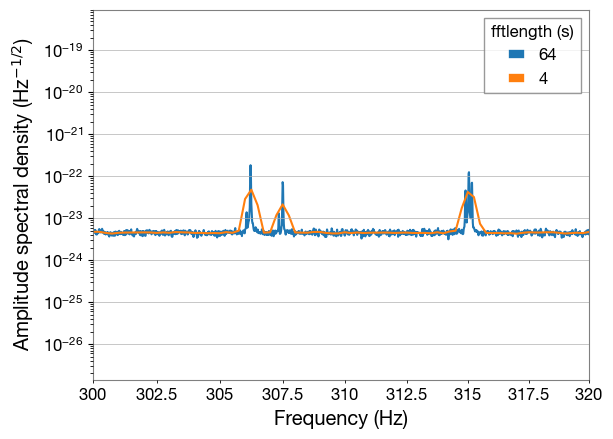

In [4]:
for xlim in None, (15, 1500), (300, 320):
    plt.figure()
    for fftlength in 64, 4:
        asd = timeseries.asd(fftlength=fftlength, method="median")
        plt.loglog(asd.frequencies, asd, label=fftlength)
    plt.xlim(xlim)
    plt.legend(title='fftlength (s)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude spectral density (Hz$^{-1/2}$)')

Note that a longer FFT length resolves better the lines but is more noisy in the continuum.

* Why does the ASD have units of $1/\sqrt{\text{Hz}}$?
* What is the Nyquist frequency?
* What is the sampling frequency?
* What is the frequency band of potential signals that you could analyze with these data?

# Whitening the data

For stationary Gaussian noise, the covariance matrix is diagonal in frequency space:
$$
\langle n(f) n^*(f') \rangle = \frac{1}{2} S(f) \delta(f - f')
$$
Therefore it is very easy to invert this matrix, we can simply rescale the different frequencies by $S(f)^{-1/2}$.
We define the whitened data as
$$
\tilde d_\text{white}(f) = \frac{\tilde d(f)}{\sqrt{S(f)}}
$$
The whitened data has a flat PSD (by definition):

Text(0.5, 0, '')

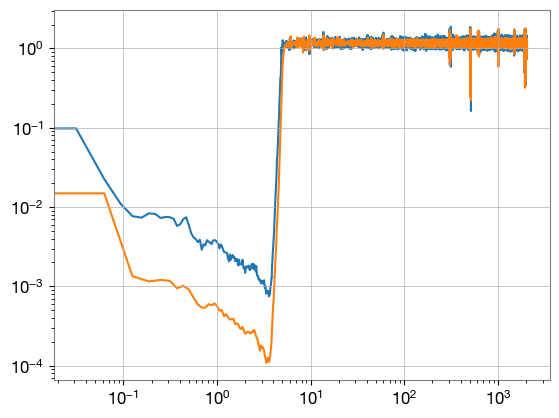

In [5]:
plt.figure()
for fftlength in 32, 16:
    whitened = timeseries.whiten(fftlength=fftlength, fduration=fftlength, detrend='linear')
    asd_w = whitened.asd(fftlength=fftlength)
    plt.loglog(asd_w.frequencies, asd_w * (len(whitened))**.25)

plt.xlabel('')

Let us explore more the properties of whitened vs. unfiltered data. Zoom in around a random 5s segment:

In [6]:
xlim = whitened.times.value[0] + (300, 305)

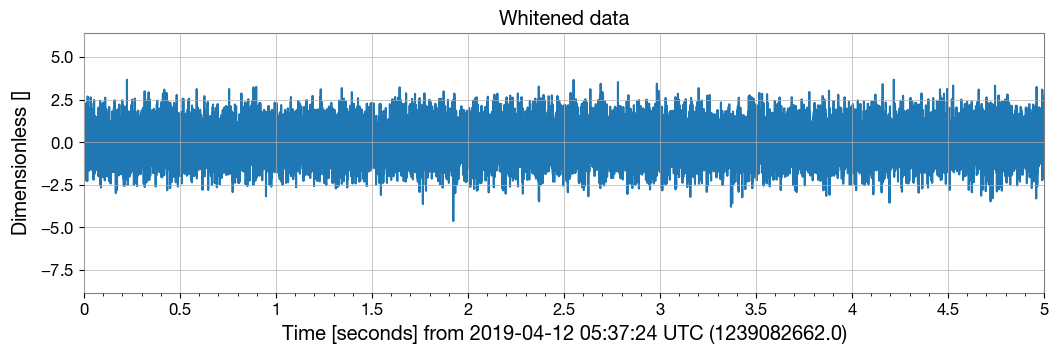

In [7]:
whitened.plot(xlim=xlim, title='Whitened data');

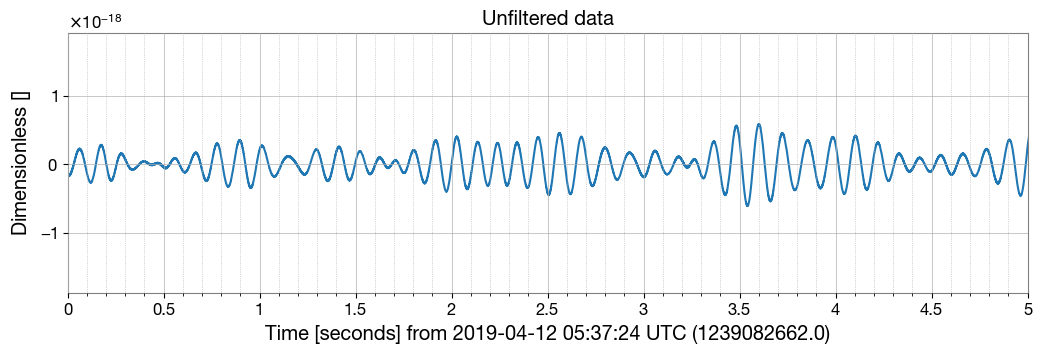

In [8]:
timeseries.plot(xlim=xlim, title='Unfiltered data');
plt.grid(which='minor', linestyle=':')

First, note of all that the units are very different. Whitened data has variance 1, while unfiltered data has variance given by the integral of the detector PSD.

The correlations in the data are very different too: white noise is uncorrelated (every sample takes an independent random value $\sim \mathcal{N}(0, 1)$, i.e. from a normal distribution with 0 mean and unit variance). On the other hand, correlations are clearly visible on the unfiltered data.
The autocorrelation of the noise is a function $$C(\tau) = \langle n(t) \, n(t + \tau) \rangle,$$
where you can interpret the angled brackets as an average over $t$.

* Answer by inspecting the above plots by eye:
    - What is $C(100\,\mathrm{ms})$: positive, negative or zero? And $C(50\,\mathrm{ms})$? $C(0)$? What do you expect $C(1\,\mathrm{h})$ to be?
    - At what frequency scale do the largest correlations in the noise take place?
    - What does the PSD of the data look like at this frequency?
* Plot a histogram of the whitened data, compare it to a standard normal distribution.

## Autocorrelation of white noise

The covariance matrix of Gaussian noise in the time domain is symmetric and has constant values along diagonals ($\Sigma_{ij}$ depends on $|i-j|$). These values are given by the autocorrelation function $C(\tau)$.

For white noise, the autocorrelation function should be a delta function, since different samples are uncorrelated (equivalently, the covariance matrix is the identity matrix).

Let us check this on the whitened data:

In [9]:
import scipy.signal

In [10]:
corr_w = scipy.signal.correlate(whitened, whitened) / len(whitened)
lags = scipy.signal.correlation_lags(len(whitened), len(whitened)) * whitened.dt

Text(0.5, 0, 'Lag (s)')

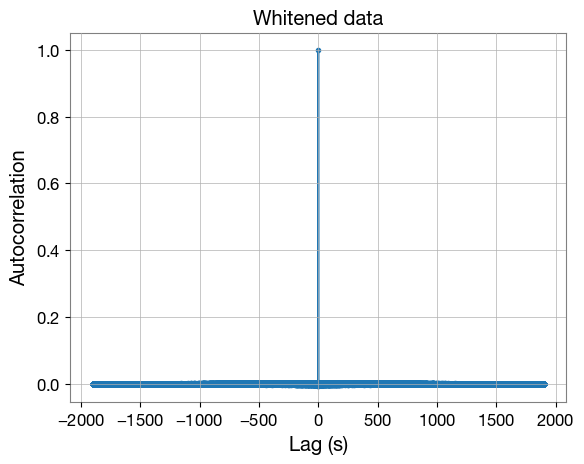

In [11]:
plt.figure()
plt.plot(lags, corr_w, '.-')
plt.title('Whitened data')
plt.ylabel('Autocorrelation')
plt.xlabel('Lag (s)')

Text(0.5, 0, 'Lag (s)')

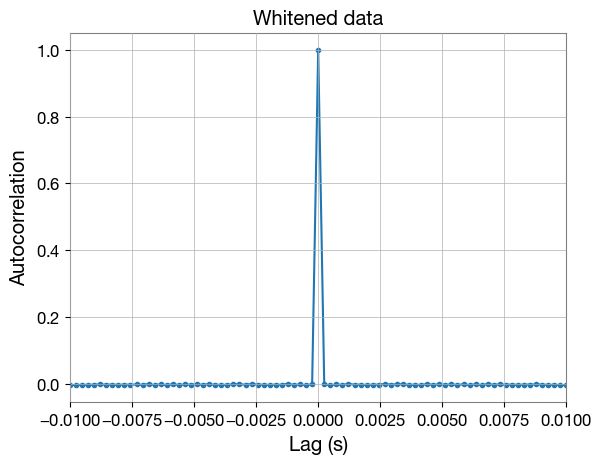

In [12]:
# Zoom-in:
plt.figure()
plt.plot(lags, corr_w, '.-')
plt.xlim(-0.01, 0.01)
plt.title('Whitened data')
plt.ylabel('Autocorrelation')
plt.xlabel('Lag (s)')

(Question: why did we divide by `len(whitened)`?)

## Autocorrelation of unfiltered noise

Let's see how this would look on unfiltered data:

In [13]:
window = scipy.signal.get_window(('tukey', 0.1), len(timeseries))
corr = scipy.signal.correlate(timeseries * window, timeseries * window)

Text(0.5, 0, 'Lag (s)')

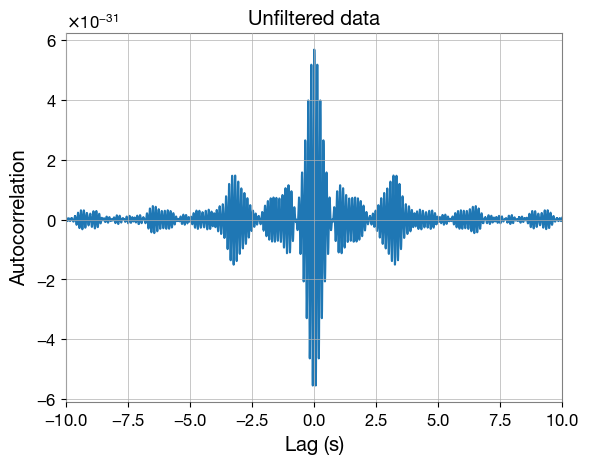

In [14]:
plt.figure()
plt.plot(lags, corr)
plt.xlim(-10, 10)
plt.title('Unfiltered data')
plt.ylabel('Autocorrelation')
plt.xlabel('Lag (s)')

* Test your earlier predictions for $C(\tau)$.
* Note that it is necessarily symmetric (why?).

We see that the autocorrelation function of the unfiltered data has very rich features.
In fact, we can reconstruct the PSD from its Fourier transform.

## The Fourier transform of the autocorrelation function is the PSD

(Wiener–Khinchin theorem)

> ### Aside: numerical computation of the Fourier transform
>
> The fast Fourier transform (FFT) is a very efficient algorithm for computing the discrete Fourier transform (DFT) numerically ($\mathcal{O}(N \log N)$ instead of naively $\mathcal{O}(N^2)$). See https://numpy.org/doc/stable/reference/routines.fft.html#module-numpy.fft for conventions in the definition of the DFT.
> Real-valued time-domain signals have redundant positive- and negative-frequency components so it is customary to only give the positive ones, this is done with the real fast Fourier transform `rfft`.

Text(0, 0.5, 'Autocorrelation in frequency domain')

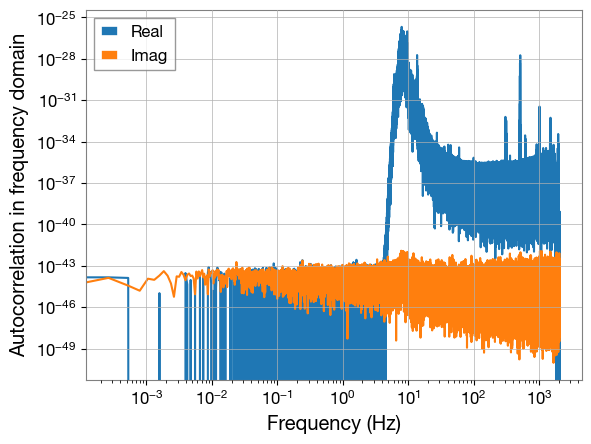

In [15]:
# Compute the Fourier transform of the autocorrelation function:
corr_fft_complex = np.fft.rfft(np.fft.ifftshift(corr))

# Define the frequency grid associated with our given time grid:
rfftfreq = np.fft.rfftfreq(len(corr), d=timeseries.dt)

plt.figure()
plt.loglog(rfftfreq, corr_fft_complex.real, label='Real')
plt.loglog(rfftfreq, np.abs(corr_fft_complex.imag), label='Imag')
plt.legend()

plt.xlabel('Frequency (Hz)')
plt.ylabel('Autocorrelation in frequency domain')

Note that, aside from numerical noise, `corr_fft_complex` is actually real valued and positive. (Why?)

Let's enforce it

In [16]:
# Take the abs to enforce that the Fourier transform of the autocorrelation is real and positive.
# To use the convention of the continuous Fourier transform, we multiply by dt
# Divide by (window**2).sum() to measure the power per frequency bin, correcting for the power taken out by the window.
corr_fft = np.abs(corr_fft_complex) * timeseries.dt / (window**2).sum()

Text(0.5, 0, 'Frequency (Hz)')

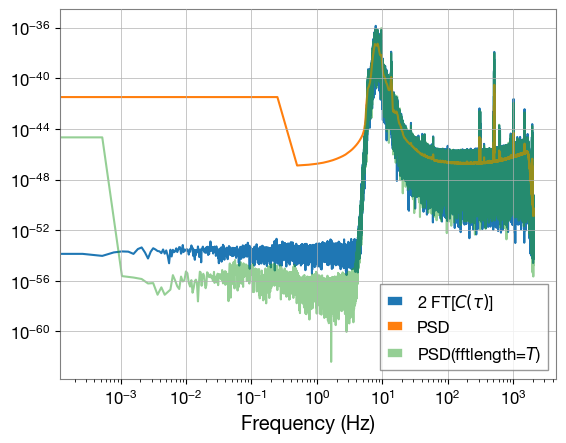

In [17]:
plt.figure()
plt.loglog(rfftfreq, corr_fft * 2, label=r'2 FT[$C(\tau)$]')  # Factor 2 because 1 sided PSD
plt.loglog(asd.frequencies, asd**2, label='PSD')

psd = timeseries.psd(fftlength=end - start)
plt.loglog(psd.frequencies, psd, alpha=.5, label='PSD(fftlength=$T$)')

plt.legend()
plt.xlabel('Frequency (Hz)')

We see that the Fourier transform of the autocorrelation function gives a noisy estimate of the PSD. It's noisy because we used only one realization to estimate it, in fact it's very similar to what we get from `gwpy` with a FFT length as long as the whole data segment.

We can improve the estimate by averaging estimates of the PSD from multiple shorter segments:

## Exercise: the Welch method

Instead of relying on `gwpy`, can you estimate the PSD "by hand", implementing the [Welch method](https://en.wikipedia.org/wiki/Welch%27s_method) yourself?

1. Divide the data in `timeseries` in segments (`timeseries[i_start : i_end]`)
2. Apply a window to each segments. Note that, as above, the window takes some power out so you have to correct the PSD estimate for that.
3. Use RFFT to compute the Fourier transform of each segment. Take the absolute value squared to build estimates of the PSD in each segment.
4. Average the estimates to reduce the uncertainty of the final estimate.

(a solution is given below, but first do it yourself)

* Extra: can you compute the whitened data from the original timeseries and the ASD?

## Other resources

For a more extended tutorial of GWpy, looking at data with signals, and additional exercises, check out the Gravitational Wave Open Data Workshop  https://github.com/gw-odw/odw-2024


#### Solution to the Welch exercise

In [18]:
segments_fft = []
fftlength = 32.0
n_inds = int(fftlength / timeseries.dt.value)
segment_window = scipy.signal.get_window('hann', n_inds)

for i_start in range(0, len(timeseries) - n_inds, n_inds // 2):  # 50% overlap between segments
    segment = timeseries[i_start : i_start + n_inds]
    segments_fft.append(np.fft.rfft(segment * segment_window))

# Factor 2 because it's the one-sided PSD
# Divide by sum(window**2) to account for loss of power due to the window
psd = 2 * np.mean(np.abs(segments_fft)**2, axis=0) * timeseries.dt.value / (segment_window**2).sum()

# Find the frequency grid that corresponds to the time grid we are using
rfftfreq_segment = np.fft.rfftfreq(n_inds, d=timeseries.dt)

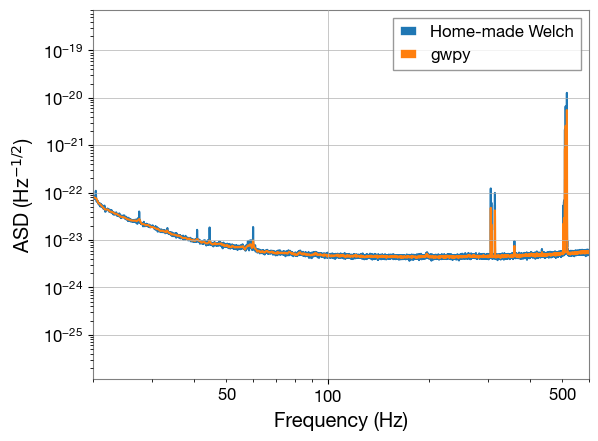

In [19]:
plt.figure()
plt.loglog(rfftfreq_segment, np.sqrt(psd), label='Home-made Welch')
plt.loglog(asd.frequencies, asd, label='gwpy')
plt.xlim(20, 600)
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD (Hz$^{-1/2}$)');